# Initialization
Import modules and define useful plotting functions

In [1]:
%matplotlib notebook 
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from scipy import integrate
import glob,sys

from mpl_toolkits.basemap import Basemap, shiftgrid

import MV2 as MV
import cdms2 as cdms
import genutil
import cdutil
import cdtime

sys.path.append("/Users/kmarvel/Google Drive/python-utils")
import Plotting


def bmap(X,projection="moll",**kwargs):
    """ quick plot of data on a lat,lon grid """
   # lon = X.getLongitude()[:]
    #lat = X.getLatitude()[:]
    
    lon = X.getLongitude().getBounds()[:,0]
    lat = X.getLatitude().getBounds()[:,0]
    vmin=None
    vmax=None
    if "vmin" in kwargs.keys():
        vmin=kwargs.pop("vmin")
    if "vmax" in kwargs.keys():
        vmax=kwargs.pop("vmax")
    if not ("lon_0" in list(kwargs.keys())):
        lon_0=np.median(lon)
    else:
        lon_0=kwargs.pop("lon_0")
        X,lon = shiftgrid(180,X,lon,start=False)
    m = Basemap(lon_0=lon_0,projection=projection,**kwargs)
    
        
    x,y=m(*np.meshgrid(lon,lat))
    #if vmin is None:
    #m.pcolormesh(x,y,X,**kwargs)
    #else:
    m.pcolor(x,y,X,vmin=vmin,vmax=vmax)
    return m

surface = {"hfls": "Surface Upward Latent Heat Flux",\
            "hfss": "Surface Upward Sensible Heat Flux",\
            "rlds":"Surface Downwelling Longwave Radiation",\
            "rlus":"Surface Upwelling Longwave Radiation",\
            "rsds":"Surface Downwelling Shortwave Radiation",\
            "rsus": "Surface Upwelling Shortwave Radiation"}
TOA = {"rsdt":"TOA Incident Shortwave Radiation",\
       "rsut": "TOA Outgoing Shortwave Radiation",\
       "rlut": "TOA Outgoing Longwave Radiation"}

Allow anonymous logging usage to help improve CDAT(you can also set the environment variable CDAT_ANONYMOUS_LOG to yes or no)? [yes]/no: no


# Data entry from RFMIP LGM experiments
Can also find info at https://cmip6workshop19.sciencesconf.org/data/Session2_PosterSlides.pdf

In [44]:
model="IPSL-CM6A-LR"
model_lgm_id="ipsl-ice6g"
datadirec="/Users/kmarvel/Documents/DATA/LGM/LGM-Adjustments/"+model_lgm_id+"/"
#datadirec="/Users/kmarvel/Documents/DATA/LGM/LGM-Adjustments/ipsl-ice6g/"

In [45]:
## Top-of-atmosphere variables

f=cdms.open(glob.glob(datadirec+"rsdt_*")[0])

rsdt=f("rsdt")

f.close()

f=cdms.open(glob.glob(datadirec+"rsut_*")[0])

rsut=f("rsut")

f.close()

f=cdms.open(glob.glob(datadirec+"rlut_*")[0])

rlut=f("rlut")

f.close()

TOA = rsdt-(rsut+rlut)

print("TOA imbalance is ", MV.average(cdutil.averager(TOA,axis='xy')))

f=cdms.open(glob.glob(datadirec+"ts_*")[0])

ts=f("ts")

f.close()

## Clear-sky fluxes

TOA imbalance is  -3.0175962397159917


## Clear-sky fluxes

In [46]:
#f=cdms.open(glob.glob(datadirec+"rsdtcs_*")[0])

#rsdtcs=f("rsdtcs")

#f.close()

f=cdms.open(glob.glob(datadirec+"rsutcs_*")[0])

rsutcs=f("rsutcs")

f.close()

f=cdms.open(glob.glob(datadirec+"rlutcs_*")[0])

rlutcs=f("rlutcs")

f.close()



In [47]:
SWCRE = (rsutcs-rsut)
LWCRE = (rlutcs-rlut)

In [48]:
print("SWCRE", MV.average(cdutil.averager(SWCRE,axis='xy'),axis=0))
print("LWCRE", MV.average(cdutil.averager(LWCRE,axis='xy'),axis=0))

SWCRE -47.40987583973462
LWCRE 25.659177387447844


## Cloud cover

In [49]:
f=cdms.open(glob.glob(datadirec+"clt_*")[0])

clt=f("clt")

f.close()

#f=cdms.open(glob.glob(datadirec+"clcalipso_*")[0])

#clcalipso=f("clcalipso")
#clisccp=f("clisccp")

#f.close()

Sanity check: does the cloud cover look ok?

<IPython.core.display.Javascript object>


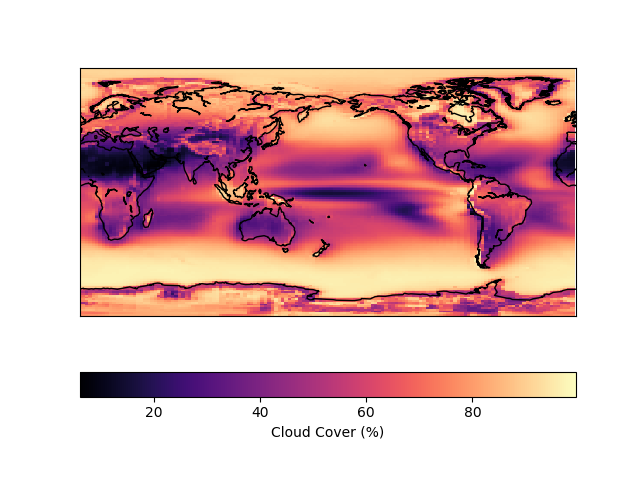

In [50]:
plt.set_cmap(cm.magma)
plt.figure()
m=bmap(MV.average(clt,axis=0),projection="cyl")
m.drawcoastlines()
cbar=plt.colorbar(orientation="horizontal",label="Cloud Cover (%)")

<IPython.core.display.Javascript object>


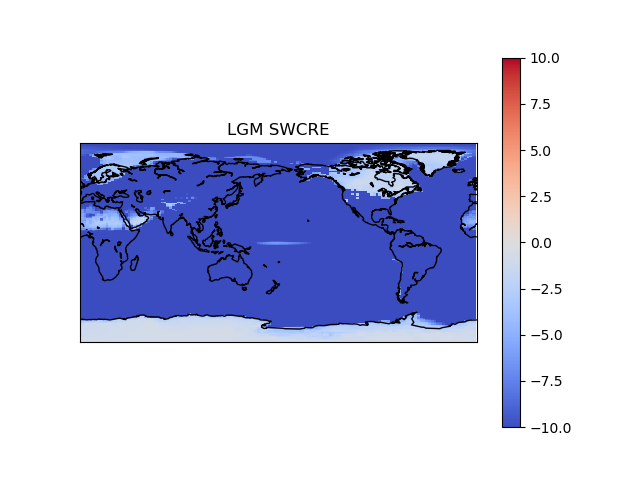

In [20]:
plt.set_cmap(cm.coolwarm)
plt.figure()
m=bmap(MV.average(SWCRE,axis=0),projection="cyl",vmin=-10,vmax=10)
plt.title("LGM SWCRE")
m.drawcoastlines()
cbar=plt.colorbar()

## Preindustrial control data

In [51]:
model="IPSL-CM6A-LR"
#pidirec="/Users/kmarvel/Documents/DATA/LGM/ProcessedFromMary/"+model+"/piControl/TimeMeans/"
pidirec="/Users/kmarvel/Documents/DATA/LGM/TimeMeans/"
#histdirec="/Users/kmarvel/Documents/DATA/LGM/ProcessedFromMary/"+model+"/historical/TimeMeans/"


#Kludge: use rsdt from LGM since it's not available for piControl.  
#rsdt_mean=MV.average(rsdt,axis=0)
#frsdt= cdms.open(histdirec+"rsdt_timemean.nc")
#rsdt_pi=frsdt("rsdt")
rsdt_pi=MV.average(rsdt,axis=0)
if model=="CESM2":
    rsdt_pi=rsdt_pi.regrid(rsdt.getGrid(),regridTool='regrid2')
#frsdt.close()
frsut=cdms.open(pidirec+"rsut_timemean.nc")
rsut_pi=frsut("rsut")
frsut.close()
frlut=cdms.open(pidirec+"rlut_timemean.nc")
rlut_pi=frlut("rlut")
frlut.close()

frsutcs=cdms.open(pidirec+"rsutcs_timemean.nc")
rsutcs_pi=frsutcs("rsutcs")
frsutcs.close()

frlutcs=cdms.open(pidirec+"rlutcs_timemean.nc")
rlutcs_pi=frlutcs("rlutcs")
frlutcs.close()

fts=cdms.open(pidirec+"ts_timemean.nc")
ts_pi=fts("ts")
fts.close()

In [52]:
TOA_LGM=MV.average(TOA,axis=0)
TOA_LGM.shape

(143, 144)

In [53]:
TOA_pi = rsdt_pi-(rsut_pi+rlut_pi)
rsut_pi.shape

(143, 144)

## TOA imbalance in the pre-industrial runs (why is it nonzero?)

In [54]:
print("TOA imbalance in the preindustrial is", float(cdutil.averager(TOA_pi,axis='xy')), "Wm-2")

TOA imbalance in the preindustrial is 0.6770084782368172 Wm-2


# Net TOA imbalance

In [55]:
print("Net TOA imbalance ",cdutil.averager(TOA_LGM,axis='xy')-cdutil.averager(TOA_pi,axis='xy'))

Net TOA imbalance  -3.6946045137432795


## Flux differences and cloud radiative effects
Huge reductions over the ice sheets, as expected.  

<IPython.core.display.Javascript object>


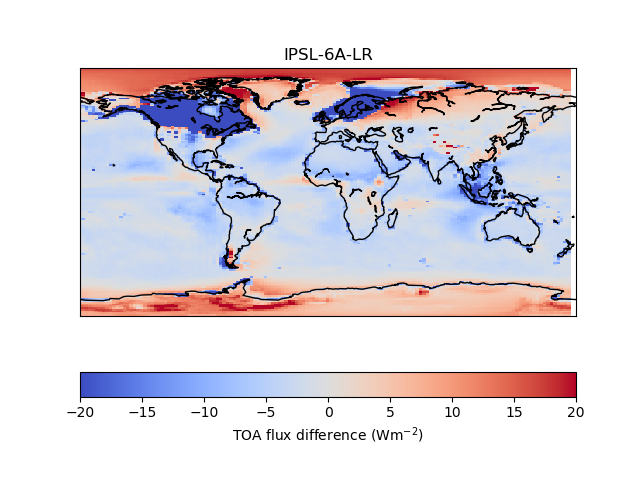

In [56]:
plt.figure()
plt.set_cmap(cm.coolwarm)
m=bmap(TOA_LGM-TOA_pi,projection="cyl",vmin=-20,vmax=20,lon_0=0)
plt.colorbar(orientation="horizontal",label=r"TOA flux difference (Wm$^{-2})$")
plt.title("IPSL-6A-LR")
m.drawcoastlines()
plt.savefig("IPSL_TOA_flux.png")

In [97]:
rsutcs.shape

(360, 143, 144)

<IPython.core.display.Javascript object>


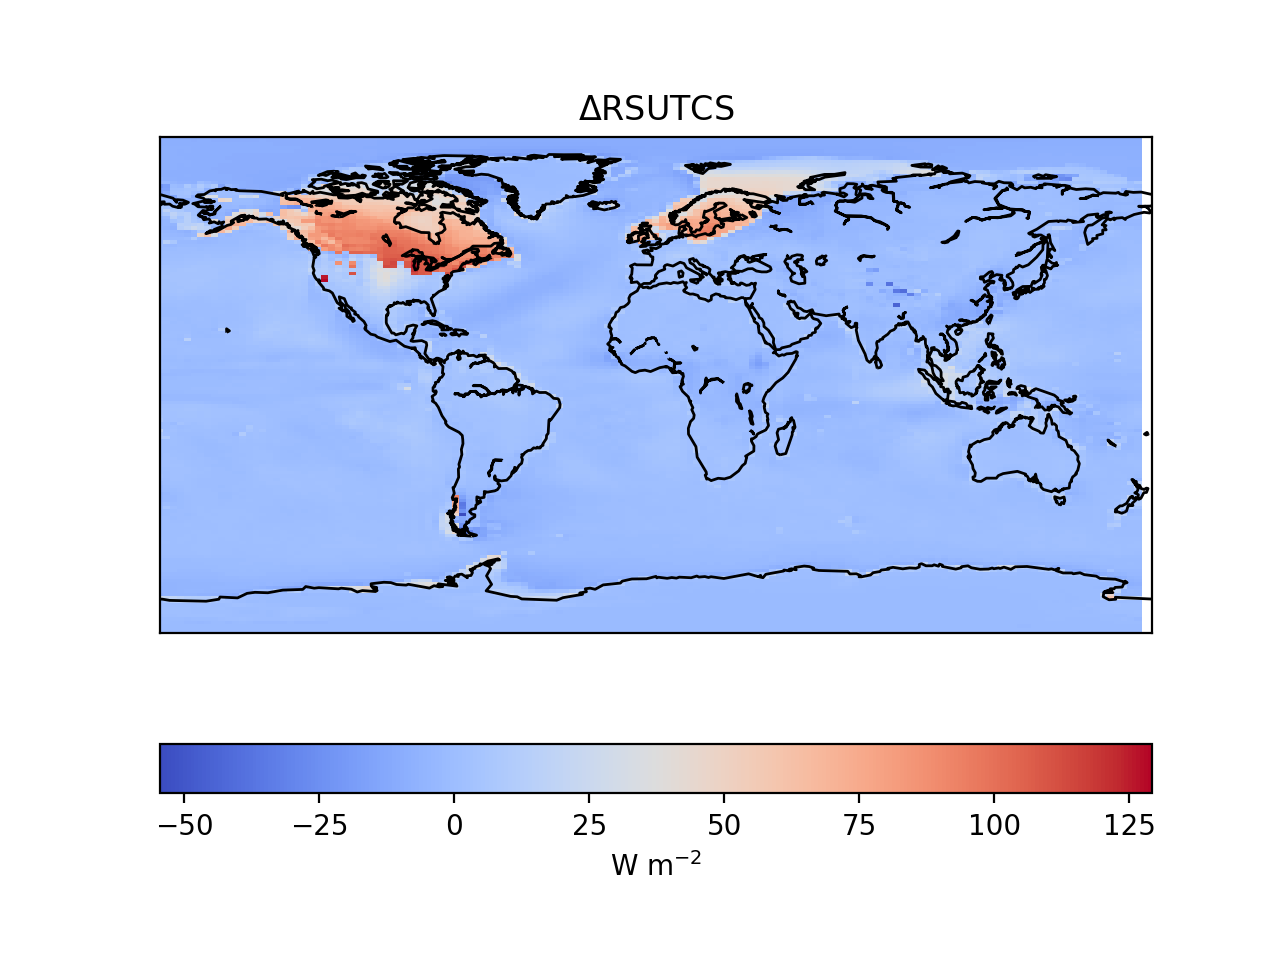

Text(0.5, 1.0, '$\\Delta$RSUTCS')

In [102]:
rsutcs_LGM=MV.average(rsutcs,axis=0)
rsut_LGM=MV.average(rsut,axis=0)
plt.figure()
m=bmap((rsut_LGM-rsut_pi),projection="cyl",lon_0=0)#,vmin=-50,vmax=50,lon_0=0)
m.drawcoastlines()
plt.colorbar(orientation="horizontal",label=r"W m$^{-2}$")
plt.title(r'$\Delta$RSUTCS')

<IPython.core.display.Javascript object>


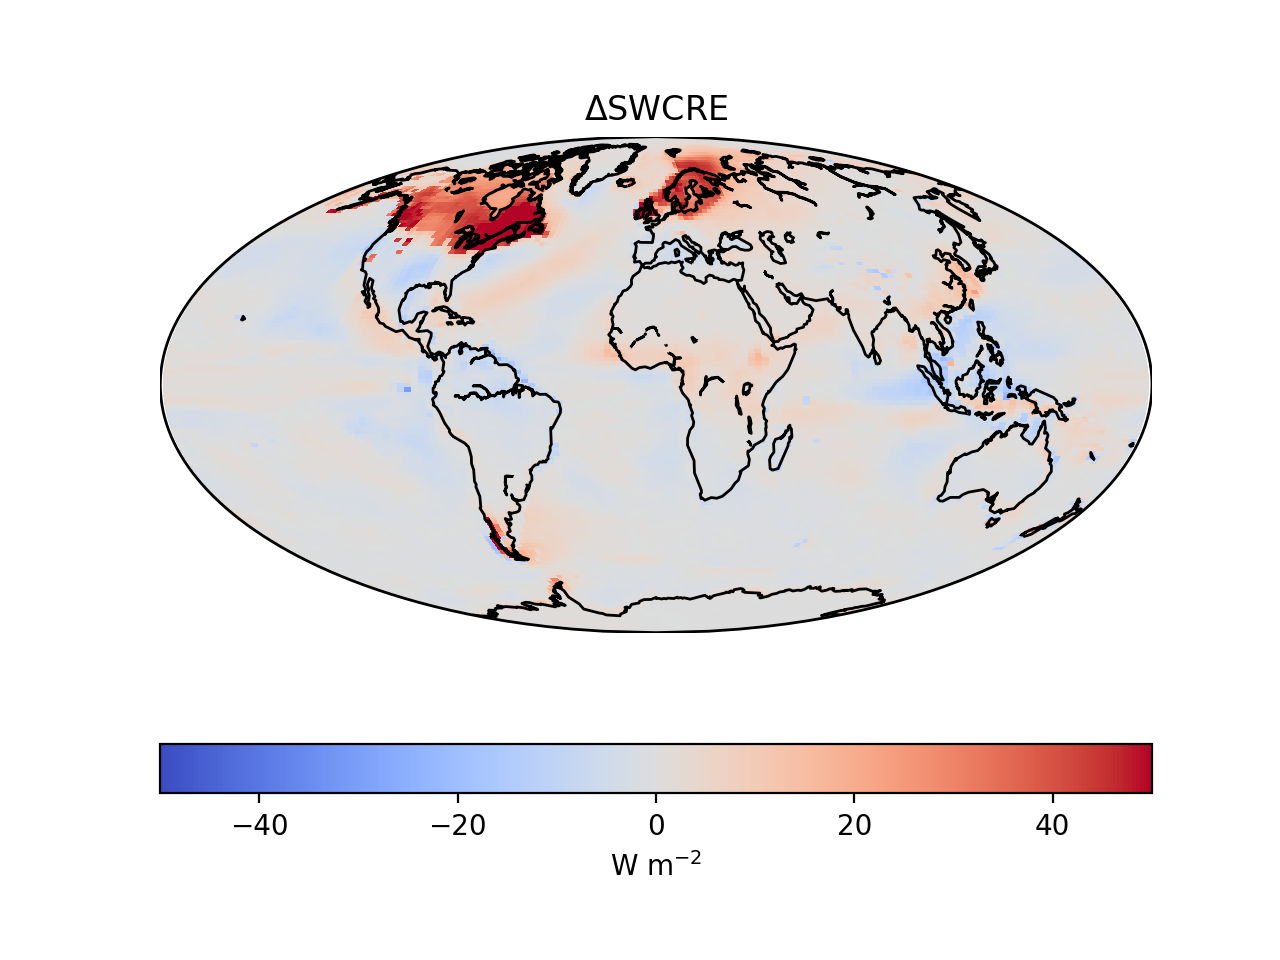

Text(0.5, 1.0, '$\\Delta$SWCRE')

In [103]:
SWCRE_LGM=MV.average(SWCRE,axis=0)
SWCRE_piC=rsutcs_pi-rsut_pi
plt.figure()
m=bmap((SWCRE_LGM-SWCRE_piC),projection="moll",vmin=-50,vmax=50,lon_0=0)
m.drawcoastlines()
plt.colorbar(orientation="horizontal",label=r"W m$^{-2}$")
plt.title(r'$\Delta$SWCRE')

In [59]:
print("SWCRE in LGM: ", cdutil.averager(SWCRE_LGM,axis='xy'))
print("SWCRE in piC: ", cdutil.averager(SWCRE_piC,axis='xy'))

SWCRE in LGM:  -47.40987566334179
SWCRE in piC:  -49.24807478976397


<IPython.core.display.Javascript object>


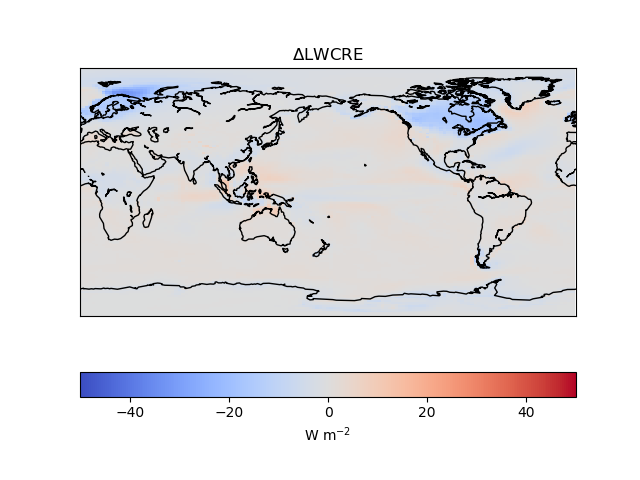

In [64]:
LWCRE_LGM=MV.average(LWCRE,axis=0)
LWCRE_piC=rlutcs_pi-rlut_pi
plt.figure()
m=bmap((LWCRE_LGM-LWCRE_piC),projection="cyl",vmin=-50,vmax=50)
m.drawcoastlines()
cbar=plt.colorbar(orientation="horizontal",label=r"W m$^{-2}$")
title=plt.title(r'$\Delta$LWCRE')

In [61]:
print("LWCRE in LGM: ", cdutil.averager(LWCRE_LGM,axis='xy'))
print("LWCRE in piC: ", cdutil.averager(LWCRE_piC,axis='xy'))

LWCRE in LGM:  25.659177447686663
LWCRE in piC:  25.90206852747305


In [65]:
print("LGM SWCRE is ",cdutil.averager(SWCRE_LGM,axis='xy'))
print("piC SWCRE is ", cdutil.averager(SWCRE_piC,axis='xy'))
print("DIFF is", cdutil.averager(SWCRE_LGM,axis='xy')-cdutil.averager(SWCRE_piC,axis='xy'))

LGM SWCRE is  -47.40987566334179
piC SWCRE is  -49.24807478976397
DIFF is 1.8381991264221753


In [66]:
print("LGM LWCRE is ",cdutil.averager(LWCRE_LGM,axis='xy'))
print("piC LWCRE is ", cdutil.averager(LWCRE_piC,axis='xy'))
print("DIFF is", cdutil.averager(LWCRE_LGM,axis='xy')-cdutil.averager(LWCRE_piC,axis='xy'))

LGM LWCRE is  25.659177447686663
piC LWCRE is  25.90206852747305
DIFF is -0.24289107978638924


<IPython.core.display.Javascript object>


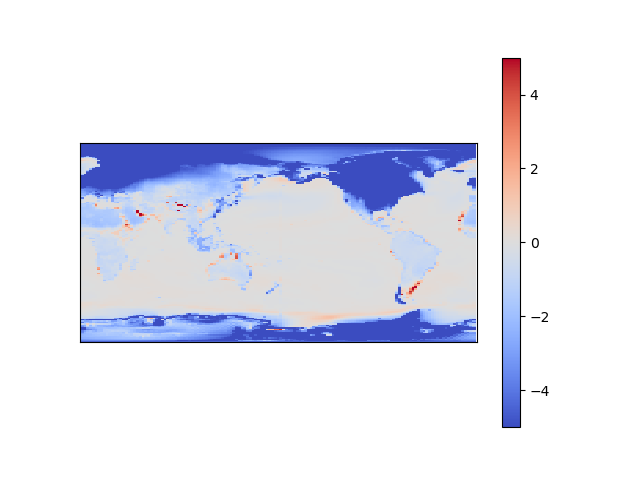

In [67]:
ts_LGM=MV.average(ts,axis=0)
dTs=ts_LGM-ts_pi
plt.figure()
bmap(dTs,projection='cyl',vmin=-5,vmax=5)
plt.colorbar()

In [68]:
print("Land cooling is",float(cdutil.averager(dTs,axis='xy')),"K")

Land cooling is -1.6604717998697383 K


In [74]:
IPSL_ECS=4.7
IPSL_F2CO2=3.23
IPSL_lam=IPSL_F2CO2/IPSL_ECS
IPSL_lam

0.6872340425531914

<IPython.core.display.Javascript object>


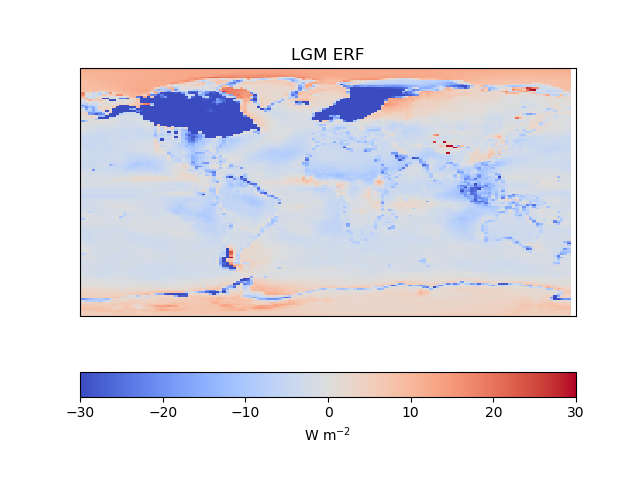

In [82]:
ERF_LGM = TOA_LGM-TOA_pi+dTs*IPSL_lam
plt.figure()
m=bmap(ERF_LGM,projection="cyl",lon_0=0,vmin=-30,vmax=30)
cbar=plt.colorbar(orientation="horizontal",label=r"W m$^{-2}$")
title=plt.title("LGM ERF")

In [83]:
print("ERF of the LGM is",cdutil.averager(ERF_LGM,axis='xy'),"Wm-2")

ERF of the LGM is -4.8357372613133345 Wm-2


In [94]:
def erf_lam(lam):
    ERF_LGM = TOA_LGM-TOA_pi+dTs*lam
    return float(cdutil.averager(ERF_LGM,axis='xy'))
erf_lam(3.7/2.)

-6.766477343502296

Cooling in IPSL_CM5 (from ftp://oceane.obs-vlfr.fr/pub/lguidi/PRIME/Pubs/kageyama%202012%20part%201.pdf): -4.48K so, assuming unit efficacy of ice sheet forcing we have (need to check 2xCO2 forcing in IPSL):

In [95]:
f=cdms.open("/Users/kmarvel/Documents/DATA/LGM/kernels/HadGEM3-GA7.1_TOA_kernel.nc")

tsurf_kernel=f("tsurf_lw")
regridded=MV.zeros((12,)+ERF_LGM.getGrid().shape)
for i in range(12):
    regridded[i]=tsurf_kernel[i].regrid(ERF_LGM.getGrid(),regridTool='regrid2')
regridded.setAxis(0,tsurf_kernel.getAxis(0))
regridded.setAxis(1,ERF_LGM.getGrid().getAxis(0))
regridded.setAxis(2,ERF_LGM.getGrid().getAxis(1))
f.close()

In [96]:
cdutil.averager(tsurf_kernel,axis='xy')

/Users/kmarvel/anaconda2/envs/cdatpy3/lib/python3.6/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]


variable_1504
masked_array(data=[-0.6877885779930627, -0.684470907069626,
                   -0.6765110470211132, -0.6833243089790655,
                   -0.6828566402821681, -0.6925446615481661,
                   -0.6870179316807088, -0.6882040094429286,
                   -0.7062917619424423, -0.6924606142169737,
                   -0.6990234568626111, -0.7072056517755382],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False],
       fill_value=1e+20)

Kernel values are negative, indicating that an increase in temperature decreases the net incoming radiation (i.e., increases the outgoing longwave radiation)

<IPython.core.display.Javascript object>


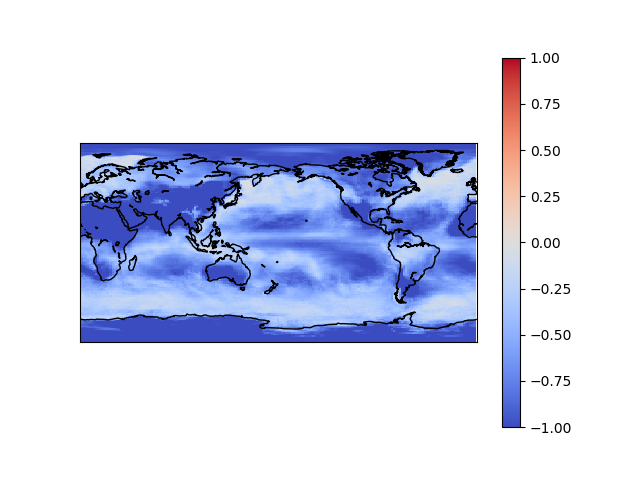

In [72]:
plt.figure()
m=bmap(tsurf_kernel[0],projection='cyl',vmin=-1,vmax=1)
m.drawcoastlines()
plt.colorbar()

In [73]:
f=cdms.open("/Users/kmarvel/Documents/DATA/LGM/ProcessedFromMary/IPSL-CM6A-LR/piControl/MonthlyMeans/ts_monthlymean.nc")

CDMSError: Cannot open file /Users/kmarvel/Documents/DATA/LGM/ProcessedFromMary/IPSL-CM6A-LR/piControl/MonthlyMeans/ts_monthlymean.nc (Attribute not found)

In [ ]:
tsmm_pi=f("ts")
f.close()

In [ ]:
regridded.shape

In [ ]:
tsmm_LGM=cdutil.ANNUALCYCLE.climatology(ts)

In [ ]:
dTs_mm=tsmm_LGM-tsmm_pi
cdutil.averager(dTs_mm,axis='xy')

In [ ]:
ERF_new=TOA_LGM-TOA_pi-MV.average(dTs_mm*regridded,axis=0)

## ERF of the IPSL-CM6A-LR MODEL

In [ ]:
print("ERF is ",cdutil.averager(ERF_new,axis='xy'),"W m-2")

In [ ]:
ECS=4.7
F2xCO2=3.23
F2xCO2_low=3.11
F2xCO2_high=3.11
